### Define the prerequisite

In [1]:
#
# Copyright 2022 NXP
# All rights reserved.
# 
# SPDX-License-Identifier: BSD-3-Clause
#

import glob
import platform
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from tensorflow import keras
from scipy import stats
from pylab import rcParams
from sklearn import metrics
from sklearn.model_selection import train_test_split
from pathlib import Path

tf.compat.v1.enable_eager_execution()
#tf.compat.v1.disable_eager_execution()

%matplotlib inline

ML_STATE_MONITOR_ML_APP_VERSION = "1.0.0"

print("ML-app version: " + ML_STATE_MONITOR_ML_APP_VERSION)
print("Python version: " + platform.python_version())
print("TF     version: " + tf.__version__)
print("Keras  version: " +keras.__version__)

np.set_printoptions(formatter={'float_kind':'{:f}'.format})

# variables
DATA_SPLIT_TRAIN_SIZE = 0 # train samples for each class (size == len(class)/STEP-1)
DATA_SPLIT_TEST_SIZE = 0

# constants
SENSOR_COLLECT_RATE_HZ = 200 # Sampling frequency
SENSOR_ACC_RESOLUTION = 2**13 # signed 14-bit resolution for X-Y-Z axis
RANDOM_SEED = 1
FEED_WINDOW = 128 # window size
FEED_WINDOW_OFST = 64 # window offset
N_CHANNELS = 3 # number of channels
N_CLASSES = 4 # number of classes

RAW_SENSOR_DATA_DIR = "in_sensor_data"
RAW_SENSOR_DATA_FN = RAW_SENSOR_DATA_DIR + "/" + "in_sensor_data" + ".txt"
RAW_SENSOR_DATA_EXTENSION = "*.csv"

ADJUST_TRAIN_SIZE_EN = 1 # adjust the train size based on provided files
TRAIN_DATA_DIR = RAW_SENSOR_DATA_DIR + "/" + "training"
TEST_DATA_DIR = RAW_SENSOR_DATA_DIR + "/" + "validation"

FILTER_DATASET_EN = 1 # filter corrupted data
FILTER_LABELS = ["FAN-CLOG", "FAN-FRICTION", "FAN-OFF", "FAN-ON"]

GENERATE_GLOW_BUNDLE_EN = 1 # generate the glow bundle by executing C:\nxp\Glow\bin\model-compiler.exe

ML-app version: 1.0.0
Python version: 3.8.3
TF     version: 2.3.0
Keras  version: 2.4.0


### Import the dataset

In [2]:
# Import the raw data

# merge all input files
all_filenames = [i for i in Path(RAW_SENSOR_DATA_DIR).rglob(RAW_SENSOR_DATA_EXTENSION)]
for f in all_filenames: print(f)
combined_csv = pd.concat([pd.read_csv(f, error_bad_lines=False) for f in all_filenames])

# filter the input dataset
dataset_size = combined_csv.shape[0]
if FILTER_DATASET_EN:
    # Remove rows that have missing values/fields
    combined_csv.dropna(inplace=True)
    
    # Remove rows that doesn't match the monitored labels
    # combined_csv.drop(combined_csv.index[~combined_csv["class"].isin(FILTER_LABELS)], inplace=True)
    combined_csv = combined_csv[combined_csv['class'].isin(FILTER_LABELS)]
    
    if dataset_size != combined_csv.shape[0]:
        print("\nWARN: Corrupted dataset detected (" + str(dataset_size - combined_csv.shape[0]) + " lines dropped) \n")
        
    dataset_size = combined_csv.shape[0]
        
# export to csv
combined_csv.to_csv(RAW_SENSOR_DATA_FN, index=False, encoding='utf-8-sig')

sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8

# define the format for each instance/row within the input files
columns = ['class','time[ms]','Ax', 'Ay', 'Az', 'Bx', 'By', 'Bz', 'temp']
ds = pd.read_csv(RAW_SENSOR_DATA_FN, header = 0, names = columns)
ds_no_norm = pd.read_csv(RAW_SENSOR_DATA_FN, header = 0, names = columns)

# extract the labels
classes_name = []
for class_type in ds['class']:
    if class_type not in classes_name:
        classes_name.append(class_type)

# generate the train-test split
if ADJUST_TRAIN_SIZE_EN:
    tr_filenames = [i for i in Path(TRAIN_DATA_DIR).rglob(RAW_SENSOR_DATA_EXTENSION)]
    tr_combined = pd.concat([pd.read_csv(f, error_bad_lines=False) for f in tr_filenames])
    if FILTER_DATASET_EN:
        tr_combined.dropna(inplace=True)
        tr_combined = tr_combined[tr_combined['class'].isin(FILTER_LABELS)]
        
    tr_sz = [sz for sz in tr_combined['class'].value_counts()]
    DATA_SPLIT_TRAIN_SIZE = min(tr_sz)//FEED_WINDOW_OFST - 1

    te_filenames = [i for i in Path(TEST_DATA_DIR).rglob(RAW_SENSOR_DATA_EXTENSION)]
    te_combined = pd.concat([pd.read_csv(f, error_bad_lines=False) for f in te_filenames])
    if FILTER_DATASET_EN:
        te_combined.dropna(inplace=True)
        te_combined = te_combined[te_combined['class'].isin(FILTER_LABELS)]
        
    te_sz = [sz for sz in te_combined['class'].value_counts()]
    DATA_SPLIT_TEST_SIZE = min(te_sz)//FEED_WINDOW_OFST - 1
    
print("Classes: " + str(classes_name))
print("Full dataset shape: " + str(ds.shape))
print("Training dataset size: " + str(DATA_SPLIT_TRAIN_SIZE))
print("Validation dataset size: " + str(DATA_SPLIT_TEST_SIZE))
ds.head()

in_sensor_data\training\200Hz_5Vfan-1-tr-clog.csv
in_sensor_data\training\200Hz_5Vfan-1-tr-friction.csv
in_sensor_data\training\200Hz_5Vfan-1-tr-off.csv
in_sensor_data\training\200Hz_5Vfan-1-tr-on.csv
in_sensor_data\training\200Hz_5Vfan-3-tr-clog.csv
in_sensor_data\training\200Hz_5Vfan-3-tr-friction.csv
in_sensor_data\training\200Hz_5Vfan-3-tr-off.csv
in_sensor_data\training\200Hz_5Vfan-3-tr-on.csv
in_sensor_data\validation\200Hz_5Vfan-1-vd1-clog.csv
in_sensor_data\validation\200Hz_5Vfan-1-vd1-friction.csv
in_sensor_data\validation\200Hz_5Vfan-1-vd1-off.csv
in_sensor_data\validation\200Hz_5Vfan-1-vd1-on.csv
in_sensor_data\validation\200Hz_5Vfan-1-vd2-clog.csv
in_sensor_data\validation\200Hz_5Vfan-1-vd2-friction.csv
in_sensor_data\validation\200Hz_5Vfan-1-vd2-off.csv
in_sensor_data\validation\200Hz_5Vfan-1-vd2-on.csv
in_sensor_data\validation\200Hz_5Vfan-1-vd3-clog.csv
in_sensor_data\validation\200Hz_5Vfan-1-vd3-friction.csv
in_sensor_data\validation\200Hz_5Vfan-1-vd3-off.csv
in_sensor_

,class,time[ms],Ax,Ay,Az,Bx,By,Bz,temp
0,FAN-CLOG,7,-166,68,4090,37,18,3,25
1,FAN-CLOG,12,-31,143,4037,-6,6,-26,25
2,FAN-CLOG,17,-18,37,4150,22,11,33,26
3,FAN-CLOG,22,20,-96,4090,14,3,26,26
4,FAN-CLOG,27,-124,-205,4111,-1,24,-54,26


FAN-CLOG        1860000
FAN-FRICTION    1860000
FAN-OFF         1860000
FAN-ON          1860000
Name: class, dtype: int64
(7440000, 9)


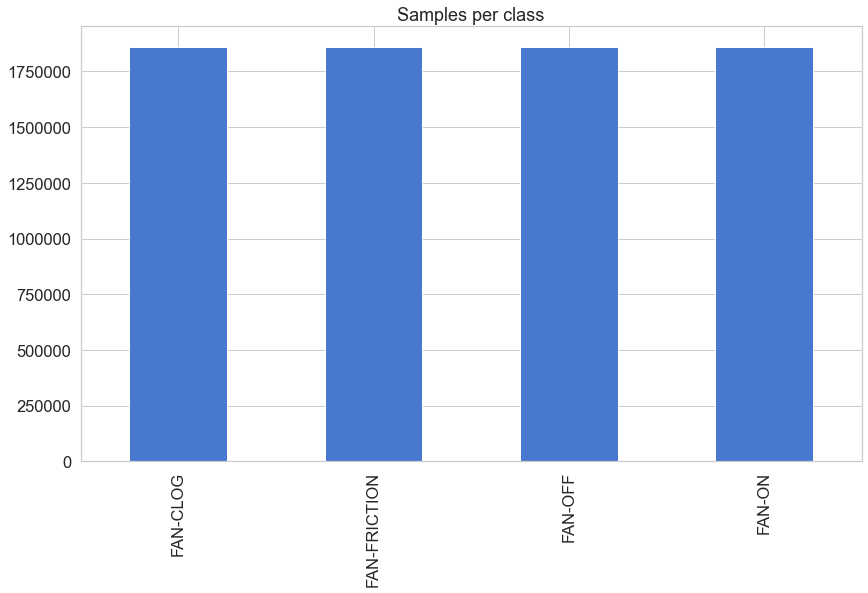

In [3]:
ds['class'].value_counts().sort_index().plot(kind='bar', title='Samples per class');
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
print(ds['class'].value_counts().sort_index())
print(np.shape(ds))

### Plot and analyze the raw data

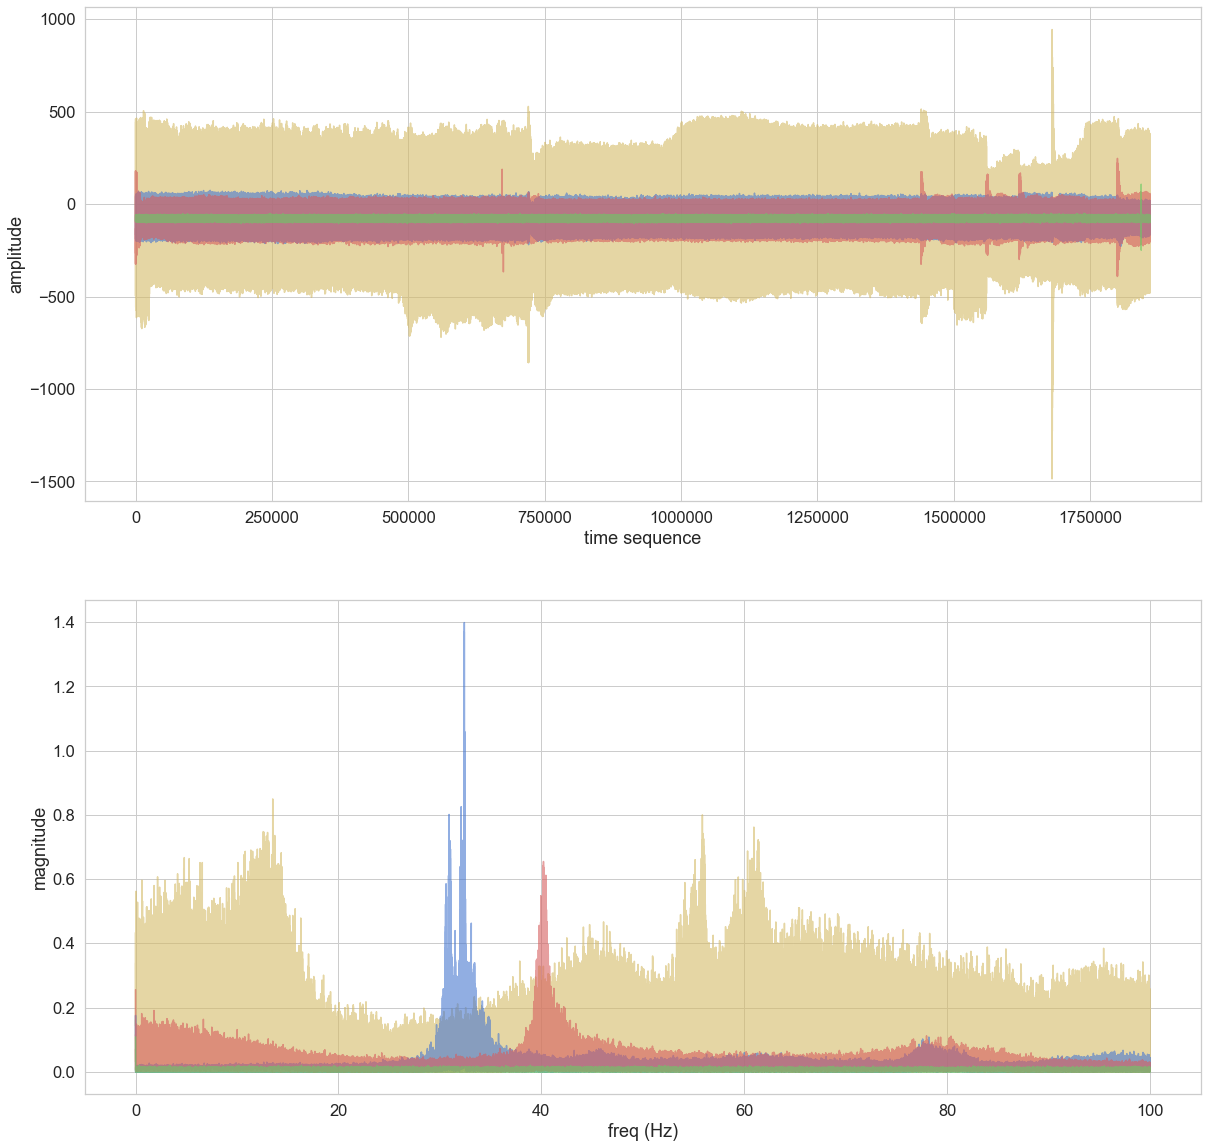

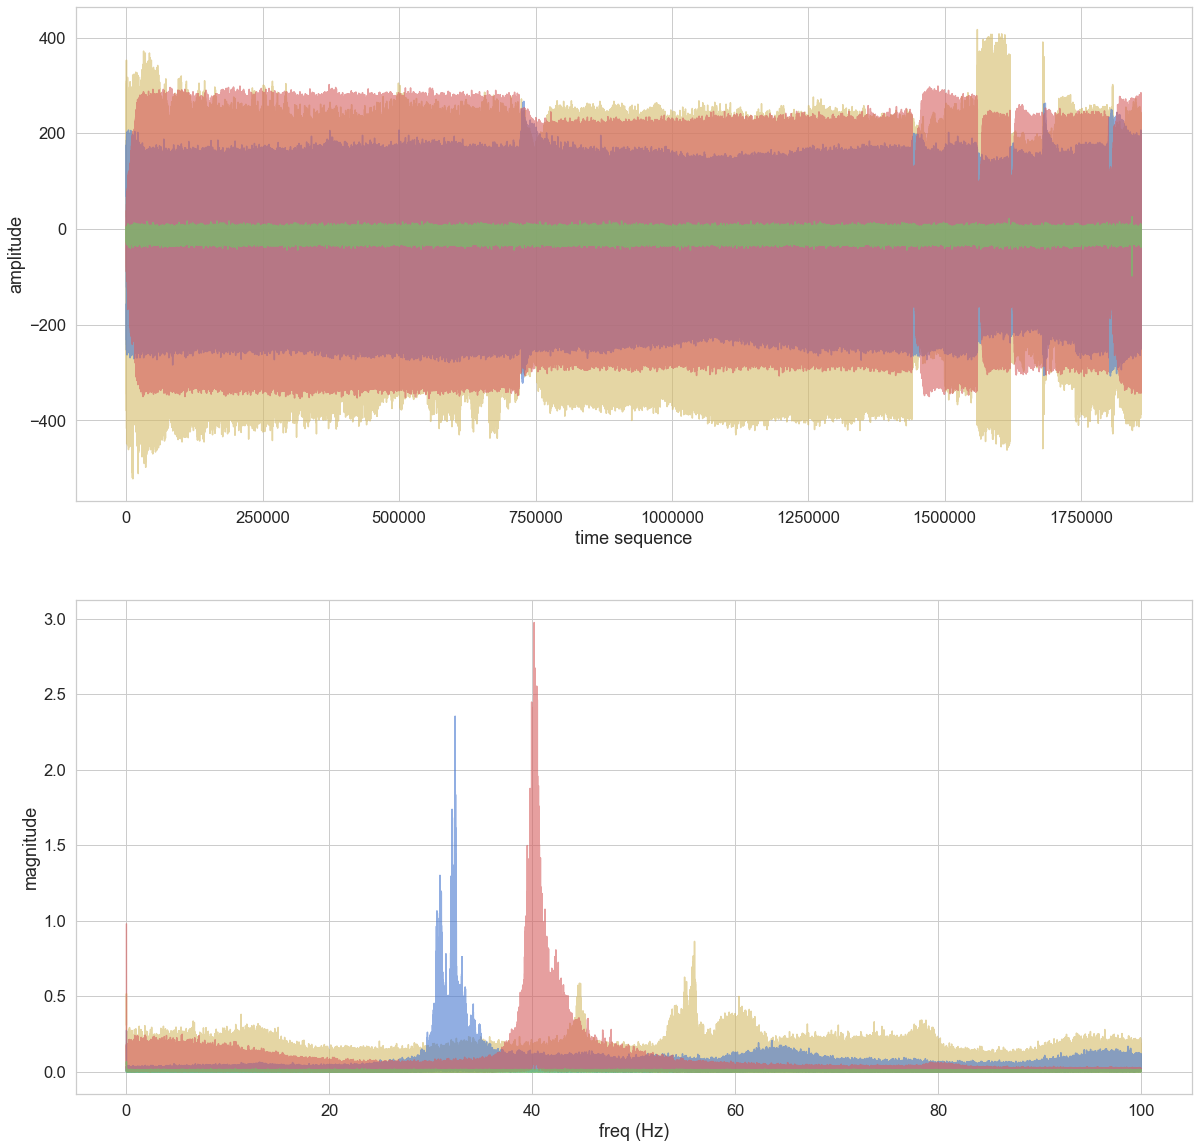

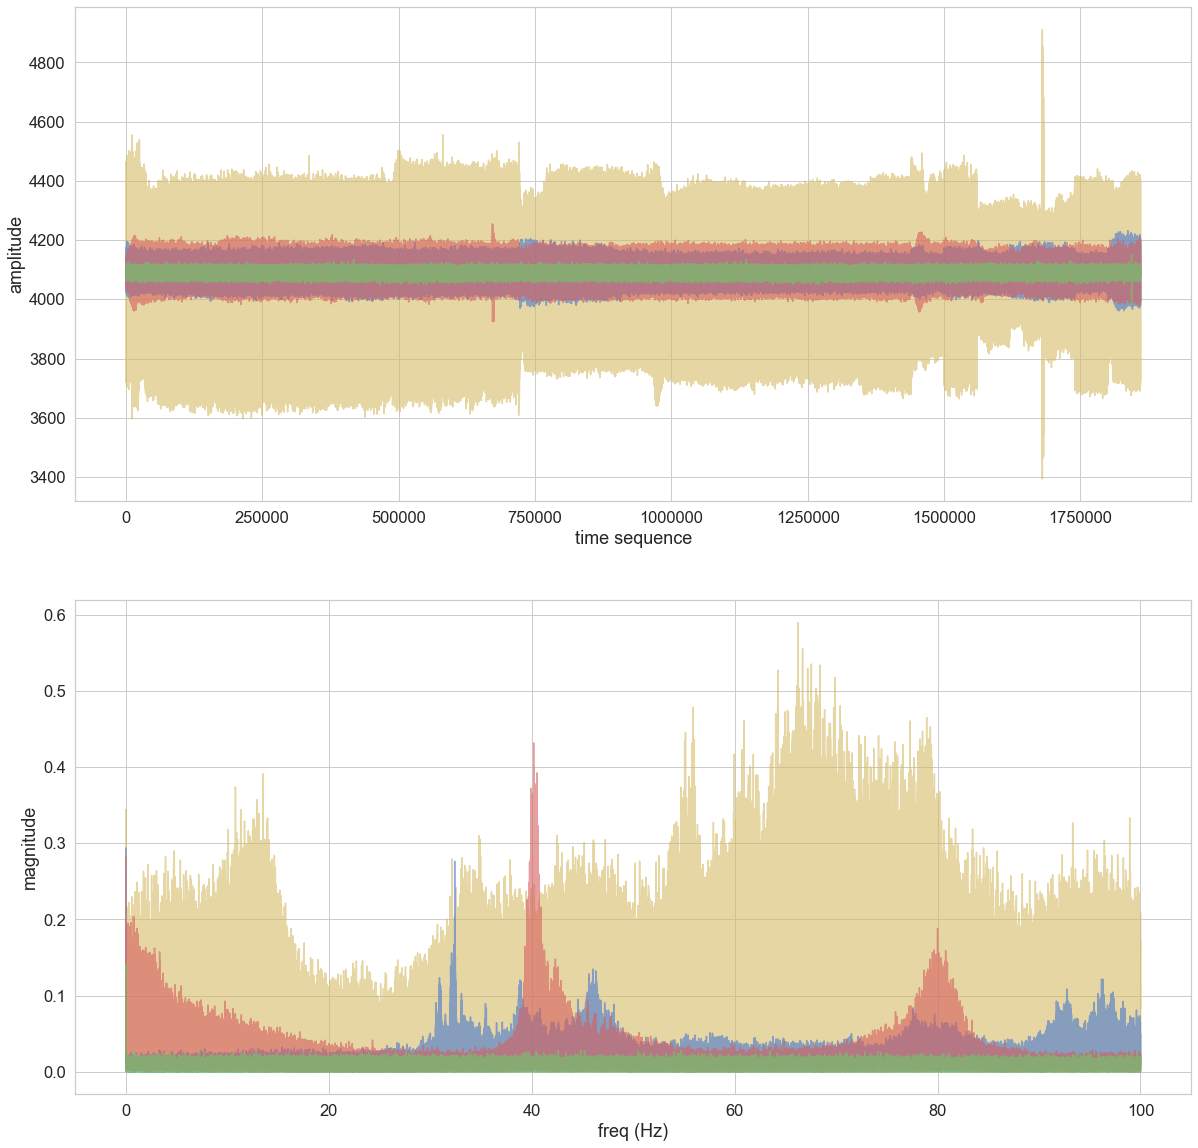

In [4]:
# Plot frequency-domain
def plot_fft_by_class_multiple(signal, lineformat, size):
    from scipy.fft import fft, ifft
    
    # Compute the frequency spectrum
    Y = []
    for insign in signal:
        fft = np.fft.fft(insign)/size
        fft = fft[range(size//2)]
        Y.append(fft)
    freq = ((np.arange(size)*SENSOR_COLLECT_RATE_HZ)/size)[range(size//2)]
    
    plt.figure(figsize=(20, 20))
    plt.subplot(2,1,1)
    for i in range(np.shape(signal)[0]):
        plt.plot(np.arange(0, size), signal[i], lineformat[i], alpha=0.6)
#     plt.ylim(-100, 100)
    plt.xlabel('time sequence')
    plt.ylabel('amplitude')
    plt.ticklabel_format(useOffset=False, style='plain')
    
    plt.subplot(2,1,2)
    for i in range(np.shape(Y)[0]):
        plt.plot(freq[1:], abs(Y[i])[1:], lineformat[i], alpha=0.6)
#     plt.ylim(0, 1)
    plt.xlabel('freq (Hz)')
    plt.ylabel('magnitude')

sz_cls = [sz for sz in ds['class'].value_counts()]
plot_sz = min(sz_cls)
plot_color = ['y-', 'b-', 'r-', 'g-']

signFANCLOG = (ds[ds['class'] == "FAN-CLOG"][['Ax']]).values.reshape(-1)
signFANFRICT = (ds[ds['class'] == "FAN-FRICTION"][['Ax']]).values.reshape(-1)
signFANOFF = (ds[ds['class'] == "FAN-OFF"][['Ax']]).values.reshape(-1)
signFANON = (ds[ds['class'] == "FAN-ON"][['Ax']]).values.reshape(-1)
plot_sign = [signFANFRICT[:plot_sz], signFANCLOG[:plot_sz], signFANON[:plot_sz], signFANOFF[:plot_sz]]
plot_fft_by_class_multiple(plot_sign, plot_color, plot_sz)

signFANCLOG = (ds[ds['class'] == "FAN-CLOG"][['Ay']]).values.reshape(-1)
signFANFRICT = (ds[ds['class'] == "FAN-FRICTION"][['Ay']]).values.reshape(-1)
signFANOFF = (ds[ds['class'] == "FAN-OFF"][['Ay']]).values.reshape(-1)
signFANON = (ds[ds['class'] == "FAN-ON"][['Ay']]).values.reshape(-1)
plot_sign = [signFANFRICT[:plot_sz], signFANCLOG[:plot_sz], signFANON[:plot_sz], signFANOFF[:plot_sz]]
plot_fft_by_class_multiple(plot_sign, plot_color, plot_sz)

signFANCLOG = (ds[ds['class'] == "FAN-CLOG"][['Az']]).values.reshape(-1)
signFANFRICT = (ds[ds['class'] == "FAN-FRICTION"][['Az']]).values.reshape(-1)
signFANOFF = (ds[ds['class'] == "FAN-OFF"][['Az']]).values.reshape(-1)
signFANON = (ds[ds['class'] == "FAN-ON"][['Az']]).values.reshape(-1)
plot_sign = [signFANFRICT[:plot_sz], signFANCLOG[:plot_sz], signFANON[:plot_sz], signFANOFF[:plot_sz]]
plot_fft_by_class_multiple(plot_sign, plot_color, plot_sz)

In [5]:
# Plot time-domain
def plot_all(ds):
    data = ds[['Ax', 'Ay', 'Az']]
    axis = data.plot(subplots=True, figsize=(15, 10), title='All classes')
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))
        ax.ticklabel_format(useOffset=False, style='plain')
        
def plot_class(classes, ds):
    title = ' '
    data = []
    for class_name in classes:
        class_data = ds[ds['class'] == class_name][['Ax', 'Ay', 'Az']]
        data.append(class_data)
        title = title + class_name + ' '
    data = pd.concat(data)
    axis = data.plot(subplots=True, figsize=(15, 10), title=title)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))
        ax.ticklabel_format(useOffset=False, style='plain')
        
def plot_class_interval(class_name, ds, ist, isp):
    from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
    data = ds[ds['class'] == class_name][['Ax', 'Ay', 'Az']][ist:isp]
    axis = data.plot(subplots=True, figsize=(15, 10), title=class_name)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))
        ax.ticklabel_format(useOffset=False, style='plain')
        
        # Change major ticks to show every 20
        ax.xaxis.set_major_locator(MultipleLocator(20))
        ax.yaxis.set_major_locator(MultipleLocator(20))

        # Change minor ticks to show every 2 (20/10 = 2)
        ax.xaxis.set_minor_locator(AutoMinorLocator(10))
        ax.yaxis.set_minor_locator(AutoMinorLocator(10))
        
        # Turn grid on for major and minor ticks
        ax.grid(which='major', color='#CCCCCC', linestyle='--')
        ax.grid(which='minor', color='#CCCCCC', linestyle=':')

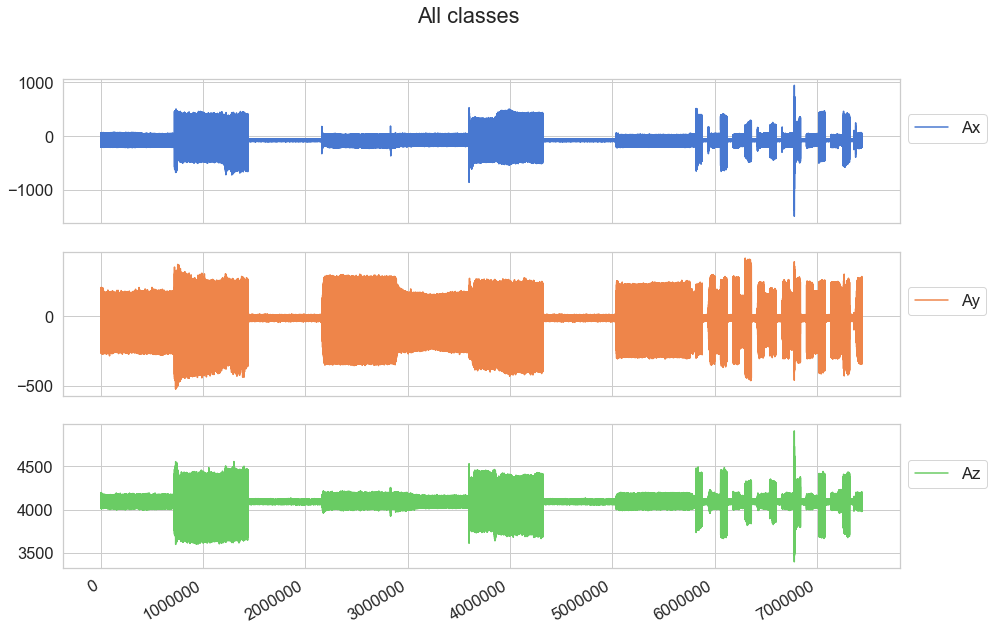

In [6]:
plot_all(ds)

In [7]:
# plot_class(["FAN-CLOG", "FAN-FRICTION", "FAN-OFF", "FAN-ON"], ds)
# plot_class(["FAN-CLOG"], ds)
# plot_class(["FAN-FRICTION"], ds)
# plot_class(["FAN-OFF"], ds)
# plot_class(["FAN-ON"], ds)

In [8]:
# plot_class_interval("FAN-CLOG", ds, 200, 400)
# plot_class_interval("FAN-FRICTION", ds, 200, 400)
# plot_class_interval("FAN-OFF", ds, 200, 400)
# plot_class_interval("FAN-ON", ds, 200, 400)

### Normalize the raw data

In [9]:
def dataset_normalization_fixed(dataset, range_data, range_norm):
    min_data, max_data = range_data[0], range_data[1]
    min_norm, max_norm = range_norm[0], range_norm[1]
    dataset_norm = (dataset - min_data) / (max_data - min_data)
    dataset_norm = dataset_norm * (max_norm - min_norm) + min_norm
    return dataset_norm

# ds[['Ax']] = dataset_normalization_fixed(ds[['Ax'], [-SENSOR_ACC_RESOLUTION, SENSOR_ACC_RESOLUTION], [-1, 1])
# ds[['Ay']] = dataset_normalization_fixed(ds[['Ay'], [-SENSOR_ACC_RESOLUTION, SENSOR_ACC_RESOLUTION], [-1, 1])
# ds[['Az']] = dataset_normalization_fixed(ds[['Az'], [-SENSOR_ACC_RESOLUTION, SENSOR_ACC_RESOLUTION], [-1, 1])

In [10]:
# Preprocess the raw data
ds[['Ax', 'Ay', 'Az']] /= SENSOR_ACC_RESOLUTION # reduce to fixed range [-1, 1]
print(ds.shape)
ds.head()

(7440000, 9)


,class,time[ms],Ax,Ay,Az,Bx,By,Bz,temp
0,FAN-CLOG,7,-0.020264,0.008301,0.499268,37,18,3,25
1,FAN-CLOG,12,-0.003784,0.017456,0.492798,-6,6,-26,25
2,FAN-CLOG,17,-0.002197,0.004517,0.506592,22,11,33,26
3,FAN-CLOG,22,0.002441,-0.011719,0.499268,14,3,26,26
4,FAN-CLOG,27,-0.015137,-0.025024,0.501831,-1,24,-54,26


### Split and reshape the dataset to be used as input for model training/validation

In [11]:
def data_split(ds):
    in_tensors = []
    cls_list = []
    for i in range(0, len(ds) - FEED_WINDOW_OFST, FEED_WINDOW_OFST):
        isp = i + FEED_WINDOW
        if isp > len(ds): break
        in_tensors.append([ds['Ax'].values[i:isp], ds['Ay'].values[i:isp], ds['Az'].values[i:isp]])
        cls_list.append(stats.mode(ds['class'][i:isp])[0][0])
    
    return in_tensors, cls_list

def data_reshape(tensors, cls_list):
    reshp_tens = []
    for i in range(np.array(tensors).shape[0]):
        temp = np.asarray(tensors[i], dtype= np.float32).ravel(order='F').reshape(-1, FEED_WINDOW, N_CHANNELS)
        reshp_tens.append(temp.reshape(FEED_WINDOW, 1, N_CHANNELS))

    reshp_tens = np.asarray(reshp_tens, dtype= np.float32)
    labels = np.asarray(pd.get_dummies(cls_list), dtype = np.float32)
    
    return reshp_tens, labels

def data_reshape_get_class(X, y, class_name):
    index_first = y.index(class_name)
    index_last = len(y) - 1 - y[::-1].index(class_name)
    y = np.asarray(pd.get_dummies(y), dtype = np.float32)
    X = X[index_first:index_last+1]
    y = y[index_first:index_last+1]
    
    X_reshaped = []
    for i in range(np.array(X).shape[0]):
        temp = np.asarray(X[i], dtype= np.float32).ravel(order='F').reshape(-1, FEED_WINDOW, N_CHANNELS)
        X_reshaped.append(temp.reshape(FEED_WINDOW, 1, N_CHANNELS))
    X_reshaped = np.asarray(X_reshaped, dtype= np.float32)
    return X_reshaped, y

def data_train_test_split(X, y):
    X_train, X_test, y_train, y_test = train_test_split(
            X, y, train_size=DATA_SPLIT_TRAIN_SIZE, test_size=DATA_SPLIT_TEST_SIZE, 
            random_state=RANDOM_SEED, shuffle=False)
    return X_train, X_test, y_train, y_test

In [12]:
# Extract the features from the raw dataset and sort in overlaped segments per class
X_segs = []
y_lbls = []
for class_type in classes_name:
    # print(class_type)
    s, l = data_split(ds[ds['class'] == class_type])
    X_segs = X_segs + s
    y_lbls = y_lbls + l

# Reshape and assemble the full dataset by each class
X_full, y_full = data_reshape(X_segs, y_lbls)

# Reshape the dataset per class
# X_a, y_a = data_reshape_get_class(X_segs, y_lbls, "FAN-CLOG")
# X_b, y_b = data_reshape_get_class(X_segs, y_lbls, "FAN-FRICTION")
# X_c, y_c = data_reshape_get_class(X_segs, y_lbls, "FAN-OFF")
# X_d, y_d = data_reshape_get_class(X_segs, y_lbls, "FAN-ON")
X_cls = []
y_cls = []
for class_type in classes_name:
    X, y = data_reshape_get_class(X_segs, y_lbls, class_type)
    X_cls.append(np.array(X))
    y_cls.append(np.array(y))
    
# Split the dataset in training and validation/test
X_train = []
X_test = [] 
y_train = []
y_test = []

for i in range(N_CLASSES):
    Xtr, Xte, ytr, yte = data_train_test_split(X_cls[i], y_cls[i])
    X_train.append(Xtr)
    X_test.append(Xte)
    y_train.append(ytr)
    y_test.append(yte) 
    
X_train = np.asarray(X_train, dtype= np.float32).reshape(-1, FEED_WINDOW, 1, N_CHANNELS)
X_test = np.asarray(X_test, dtype= np.float32).reshape(-1, FEED_WINDOW, 1, N_CHANNELS)
y_train = np.asarray(y_train, dtype= np.float32).reshape(-1, N_CLASSES)
y_test = np.asarray(y_test, dtype= np.float32).reshape(-1, N_CLASSES)

In [13]:
print("Full bef reshape:\t", np.shape(X_segs), np.shape(y_lbls))
print("Full aft reshape:\t", X_full.shape, y_full.shape)
print("Train shape:\t\t", X_train.shape, y_train.shape)
print("Test shape:\t\t", X_test.shape, y_test.shape)
print("Train shape/class:\t", Xtr.shape, ytr.shape)
print("Test shape/class:\t", Xte.shape, yte.shape)
for i in range(N_CLASSES):
    print(i, X_cls[i].shape, y_cls[i].shape, classes_name[i])
        
print("Classes:", N_CLASSES, classes_name)

Full bef reshape:	 (116244, 3, 128) (116244,)
Full aft reshape:	 (116244, 128, 1, 3) (116244, 4)
Train shape:		 (89996, 128, 1, 3) (89996, 4)
Test shape:		 (26244, 128, 1, 3) (26244, 4)
Train shape/class:	 (22499, 128, 1, 3) (22499, 4)
Test shape/class:	 (6561, 128, 1, 3) (6561, 4)
0 (29061, 128, 1, 3) (29061, 4) FAN-CLOG
1 (29061, 128, 1, 3) (29061, 4) FAN-FRICTION
2 (29061, 128, 1, 3) (29061, 4) FAN-OFF
3 (29061, 128, 1, 3) (29061, 4) FAN-ON
Classes: 4 ['FAN-CLOG', 'FAN-FRICTION', 'FAN-OFF', 'FAN-ON']


### If needed export the dataset to be used in the *c/c++* embedded application 

In [14]:
def dump_sensor_validation_data(name, dataset, raw_samples_count, index_start, index_stop):   
    xp = dataset[['Ax']].values[index_start:index_stop]
    yp = dataset[['Ay']].values[index_start:index_stop]
    zp = dataset[['Az']].values[index_start:index_stop]
    
    raw_line_size = 32
    sensor_data = []
    sensor_data.append(np.reshape(xp, (-1, raw_line_size)))
    sensor_data.append(np.reshape(yp, (-1, raw_line_size)))
    sensor_data.append(np.reshape(zp, (-1, raw_line_size)))

    # create an empty file
    file_name = "models/validation_data/" + name + ".h"
    open(file_name, 'w').close()

    # append the raw data to the file
    with open(file_name, "a") as file:
        file.write("\n#ifndef " + name + "_H_\n#define " + name + "_H_\n\n")
        file.write("const float " + name + "[" + str(N_CHANNELS) + "][" + str(raw_samples_count) + "] = {\n")

        for i in range(N_CHANNELS):
            file.write("{\n")
            np.savetxt(file, sensor_data[i], fmt='%f', delimiter=',', newline=',\n')
            file.write("},\n")
        file.write("};\n")
        file.write("const unsigned long " + name + "_samples = " + str(raw_samples_count) + ";\n")
        file.write("\n#endif\n")
    print("Done: " + name)

# Export the last validation dataset - vdset_3_vd3* (no of samples = 60000 => 300ms)
dataset_dump_clog = ds_no_norm[ds_no_norm['class'] == 'FAN-CLOG']
dump_sensor_validation_data("vdset_3_vd3_clog", dataset_dump_clog, 60000, -60000, np.shape(dataset_dump_clog)[0])

dataset_dump_friction = ds_no_norm[ds_no_norm['class'] == 'FAN-FRICTION']
dump_sensor_validation_data("vdset_3_vd3_friction", dataset_dump_friction, 60000, -60000, np.shape(dataset_dump_friction)[0])

dataset_dump_off = ds_no_norm[ds_no_norm['class'] == 'FAN-OFF']
dump_sensor_validation_data("vdset_3_vd3_off", dataset_dump_off, 60000, -60000, np.shape(dataset_dump_off)[0])

dataset_dump_on = ds_no_norm[ds_no_norm['class'] == 'FAN-ON']
dump_sensor_validation_data("vdset_3_vd3_on", dataset_dump_on, 60000, -60000, np.shape(dataset_dump_on)[0])

Done: vdset_3_vd3_clog
Done: vdset_3_vd3_friction
Done: vdset_3_vd3_off
Done: vdset_3_vd3_on


### Define the model architecture and the methods for training and evaluation

In [15]:
def model_train(model, trainX, trainy, batch_size, epochs, verbose):
    history = model.fit(
        trainX, trainy,
        epochs=epochs,
        batch_size=batch_size,
        #shuffle=False,
        verbose=verbose,
    )
    return history

def model_train_vd(model, trainX, trainy, testX, testy, batch_size, epochs, verbose):
    history = model.fit(
        trainX, trainy,
        epochs=epochs,
        batch_size=batch_size,
        #shuffle=False,
        validation_data=(testX, testy),
        verbose=verbose,
    )
    return history

def model_evaluate(model, testX, testy, batch_size, verbose):
    loss, acc = model.evaluate(testX, testy, batch_size=batch_size, verbose=verbose)
    print("Model evaluation:")
    print("Accuracy %.5f\tLoss %.5f" % (acc, loss))
    return loss, acc

In [16]:
def model_create(shape_in, shape_out):
    from keras.regularizers import l2
    
    tf.random.set_seed(RANDOM_SEED)

    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=shape_in, name='acceleration'))
    model.add(tf.keras.layers.Conv2D(8, (4, 1), activation='relu'))
    model.add(tf.keras.layers.Conv2D(8, (4, 1), activation='relu'))
    
    model.add(tf.keras.layers.Dropout(0.5))
    
    model.add(tf.keras.layers.MaxPool2D((8, 1), padding='valid'))
    model.add(tf.keras.layers.Flatten())
    
    model.add(tf.keras.layers.Dense(64, kernel_regularizer=l2(1e-4), bias_regularizer=l2(1e-4), activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(32, kernel_regularizer=l2(1e-4), bias_regularizer=l2(1e-4), activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(shape_out, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    
    return model

### Create and train a new model

In [17]:
model = model_create(X_full[0].shape, y_full[0].shape[0])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 125, 1, 8)         104       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 122, 1, 8)         264       
_________________________________________________________________
dropout (Dropout)            (None, 122, 1, 8)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 1, 8)          0         
_________________________________________________________________
flatten (Flatten)            (None, 120)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                7744      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0

In [18]:
history = model_train_vd(model, X_train, y_train, X_test, y_test, 32, 100, 1)
# history = model_train(model, X_train, y_train, 32, 100, 1)
# history = model_train(model, X_full, y_full, 32, 100, 1)

# hist = model_train_vd(model, X_train, y_train, X_test, y_test, 32, 100, 1)
# history.history['loss'].extend(hist.history['loss'])
# history.history['acc'].extend(hist.history['acc'])
# history.history['val_loss'].extend(hist.history['val_loss'])
# history.history['val_acc'].extend(hist.history['val_acc'])

Epoch 1/100
2813/2813 [==============================] - 12s 4ms/step - loss: 0.3077 - acc: 0.8887 - val_loss: 0.2004 - val_acc: 0.9409
Epoch 2/100
2813/2813 [==============================] - 12s 4ms/step - loss: 0.1100 - acc: 0.9790 - val_loss: 0.1655 - val_acc: 0.9493
Epoch 3/100
2813/2813 [==============================] - 12s 4ms/step - loss: 0.0921 - acc: 0.9825 - val_loss: 0.1501 - val_acc: 0.9632
Epoch 4/100
2813/2813 [==============================] - 12s 4ms/step - loss: 0.0823 - acc: 0.9843 - val_loss: 0.1716 - val_acc: 0.9465
Epoch 5/100
2813/2813 [==============================] - 12s 4ms/step - loss: 0.0766 - acc: 0.9860 - val_loss: 0.1816 - val_acc: 0.9599
Epoch 6/100
2813/2813 [==============================] - 12s 4ms/step - loss: 0.0698 - acc: 0.9866 - val_loss: 0.1352 - val_acc: 0.9667
Epoch 7/100
2813/2813 [==============================] - 12s 4ms/step - loss: 0.0625 - acc: 0.9886 - val_loss: 0.1833 - val_acc: 0.9604
Epoch 8/100
2813/2813 [=========================

Epoch 61/100
2813/2813 [==============================] - 12s 4ms/step - loss: 0.0184 - acc: 0.9970 - val_loss: 0.0877 - val_acc: 0.9838
Epoch 62/100
2813/2813 [==============================] - 12s 4ms/step - loss: 0.0184 - acc: 0.9972 - val_loss: 0.1048 - val_acc: 0.9743
Epoch 63/100
2813/2813 [==============================] - 12s 4ms/step - loss: 0.0184 - acc: 0.9969 - val_loss: 0.0891 - val_acc: 0.9837
Epoch 64/100
2813/2813 [==============================] - 11s 4ms/step - loss: 0.0178 - acc: 0.9972 - val_loss: 0.0735 - val_acc: 0.9841
Epoch 65/100
2813/2813 [==============================] - 12s 4ms/step - loss: 0.0178 - acc: 0.9970 - val_loss: 0.0800 - val_acc: 0.9831
Epoch 66/100
2813/2813 [==============================] - 12s 4ms/step - loss: 0.0169 - acc: 0.9972 - val_loss: 0.0841 - val_acc: 0.9840
Epoch 67/100
2813/2813 [==============================] - 12s 4ms/step - loss: 0.0178 - acc: 0.9972 - val_loss: 0.0672 - val_acc: 0.9854
Epoch 68/100
2813/2813 [=================

### Evaluate the trained model through confusion matrixes and history plot

In [19]:
def confusion_matrix_plot(y_true, y_pred):
    clslb = []
    for class_type in classes_name:
        clslb.append(class_type[4:9])
    cf_mat = metrics.confusion_matrix(y_true, y_pred, labels=[0,1,2,3])
    print("Accuracy %.5f" % (np.trace(cf_mat)/np.sum(cf_mat)))
    
    plt.figure(figsize=(9, 7))
    sns.heatmap(cf_mat, xticklabels=clslb, yticklabels=clslb, annot=True, fmt="d", annot_kws={'va':'top'}, cbar=False);
    sns.heatmap(cf_mat/np.sum(cf_mat), xticklabels=clslb, yticklabels=clslb, annot=True, fmt=".1%", annot_kws={'va':'bottom'});
    plt.title("Confusion matrix")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show();    
    
def confusion_matrix(model, X, y):
    y_pred = model.predict(X)
    max_test = np.argmax(y, axis=1)
    max_predictions = np.argmax(y_pred, axis=1)
    confusion_matrix_plot(max_test, max_predictions)

In [20]:
def plot_train(history):
    fig, ax1 = plt.subplots()
    ax1.plot(history.history['acc'], color='red', label='accuracy')
    ax1.set_ylabel('accuracy')
    ax1.legend(loc="lower left")

    ax2 = ax1.twinx()
    ax2.plot(history.history['loss'], color='blue', label='loss')
    ax2.set_ylabel('loss')
    ax2.legend(loc="upper left")

    plt.show()

def plot_train_metric(history, acc_loss):
    if acc_loss == "accuracy":
        plt.title("Accuracy")
        train = np.array(history.history['acc'])
        test = np.array(history.history['val_acc'])
    else:
        plt.title("Loss")
        train = np.array(history.history['loss'])
        test = np.array(history.history['val_loss'])                             

    plt.plot(train, "g-", label="Train")
    plt.plot(test, "r--", label="Test")

    plt.legend(loc='lower left', shadow=True)
    plt.ylabel('Training Progress')
    plt.xlabel('Training Epoch')
    plt.show()
    
def plot_train_session(history):
    # plt.figure(figsize=(20, 10))
    plt.plot(np.array(history.history['acc']), "r-", label="Train accuracy")
    plt.plot(np.array(history.history['loss']), "b-", label="Train loss")
    plt.plot(np.array(history.history['val_acc']), "g--", label="Test accuracy")
    plt.plot(np.array(history.history['val_loss']), "m--", label="Test loss")
    plt.title("Training session's progress over iterations")
    plt.legend(loc='center right', shadow=True)
    plt.ylabel('Training Progress')
    plt.xlabel('Training Epoch')
    plt.show()

### Import and evaluate from filesystem a previously exported model

In [21]:
# Import and evaluate a File System (Keras) Model
def evaluate_fs_model_keras(fs_model_name, X_set, y_set, batch_size):
    fs_model_keras = tf.keras.models.load_model(fs_model_name)
    loss, acc = model_evaluate(fs_model_keras, X_set, y_set, batch_size, 1)
    confusion_matrix(fs_model_keras, X_set, y_set)
    return fs_model_keras

In [22]:
# Import and evaluate a File System (TF Lite) Model
def evaluate_fs_model_tflite(fs_model_name, X_set, y_set):
    # Load TFLite model and allocate tensors
    interpreter = tf.lite.Interpreter(model_path=fs_model_name)
    # print(interpreter.get_input_details())
    interpreter.allocate_tensors()

    # Get input and output tensors
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Test model on random input data
    # input_shape = input_details[0]['shape']
    # input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
    
    y_pred_tflite_fs = []
    for i in range(X_set.shape[0]):
        interpreter.set_tensor(input_details[0]['index'], [X_set[i]])
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[0]['index'])
        y_pred_tflite_fs.append(output_data.reshape(-1))

    confusion_matrix_plot(np.argmax(y_set, axis=1), np.argmax(y_pred_tflite_fs, axis=1))

3633/3633 [==============================] - 5s 1ms/step - loss: 0.0281 - acc: 0.9953
Model evaluation:
Accuracy 0.99525	Loss 0.02806
Accuracy 0.99525


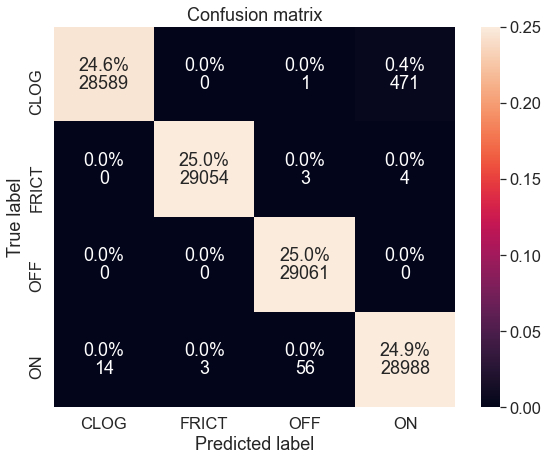

2813/2813 [==============================] - 4s 1ms/step - loss: 0.0135 - acc: 0.9981
Model evaluation:
Accuracy 0.99810	Loss 0.01355
Accuracy 0.99810


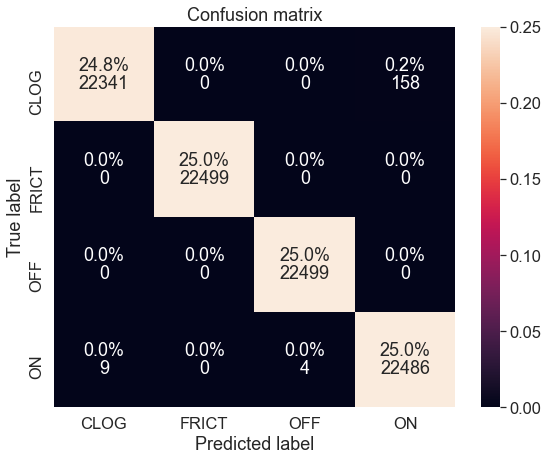

821/821 [==============================] - 1s 1ms/step - loss: 0.0779 - acc: 0.9855
Model evaluation:
Accuracy 0.98548	Loss 0.07785
Accuracy 0.98548


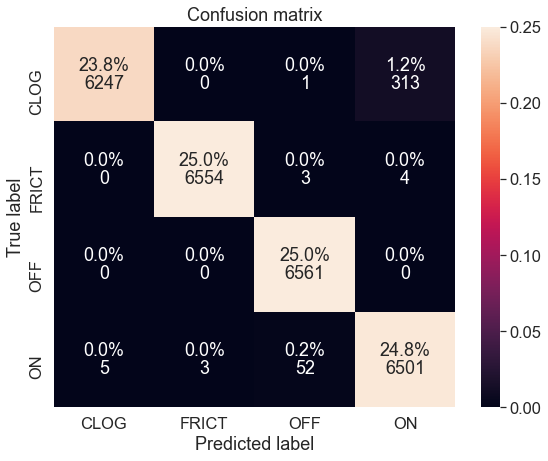

In [23]:
# Evalute the full dataset
model_evaluate(model, X_full, y_full, 32, 1)
confusion_matrix(model, X_full, y_full)

# Evaluate the training dataset
model_evaluate(model, X_train, y_train, 32, 1)
confusion_matrix(model, X_train, y_train)

# Evaluate the validation/test dataset
model_evaluate(model, X_test, y_test, 32, 1)
confusion_matrix(model, X_test, y_test)

30/30 [==============================] - 0s 2ms/step - loss: 1.0400 - acc: 0.7821
Model evaluation:
Accuracy 0.78205	Loss 1.04004
Accuracy 0.78205


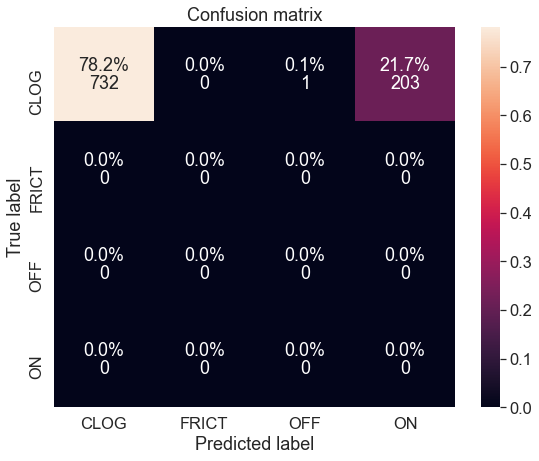

30/30 [==============================] - 0s 1ms/step - loss: 0.0041 - acc: 0.9989
Model evaluation:
Accuracy 0.99893	Loss 0.00408
Accuracy 0.99893


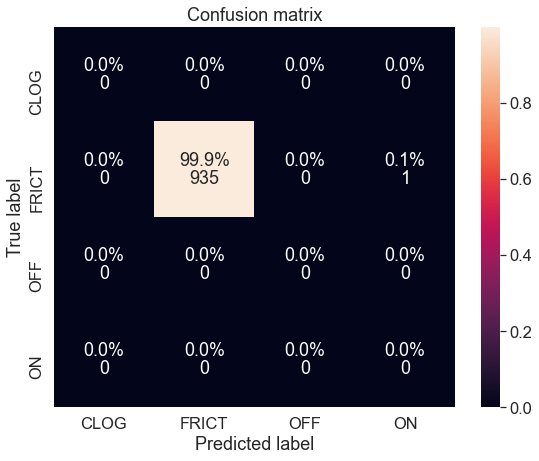

30/30 [==============================] - 0s 1ms/step - loss: 0.0032 - acc: 1.0000
Model evaluation:
Accuracy 1.00000	Loss 0.00321
Accuracy 1.00000


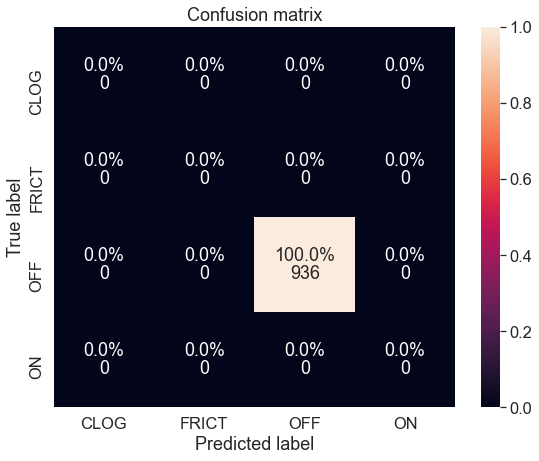

30/30 [==============================] - 0s 1ms/step - loss: 0.1702 - acc: 0.9733
Model evaluation:
Accuracy 0.97329	Loss 0.17020
Accuracy 0.97329


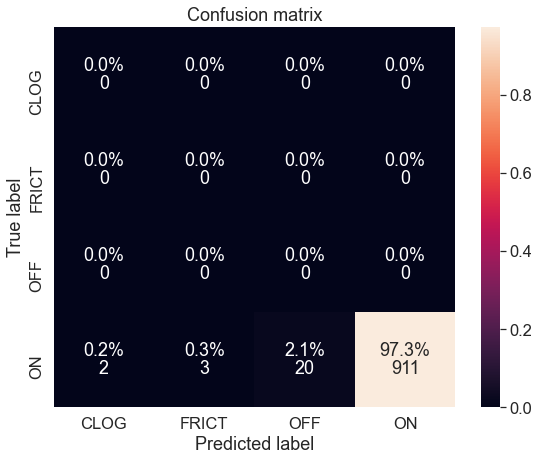

In [24]:
# Evaluate the last validation dataset - vdset_3_vd3* (no of samples = 60000 => 300ms)
vd_sz = 60000//FEED_WINDOW_OFST - 1
spl_sz = np.shape(X_cls[i])[0]

# Evaluate each class independently
spl_st = spl_sz - vd_sz
spl_sp = spl_sz
for i in range(N_CLASSES):
    X_spl = X_cls[i][spl_st:spl_sp]
    y_spl = y_cls[i][spl_st:spl_sp]
    model_evaluate(model, X_spl, y_spl, 32, 1)
    confusion_matrix(model, X_spl, y_spl)

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


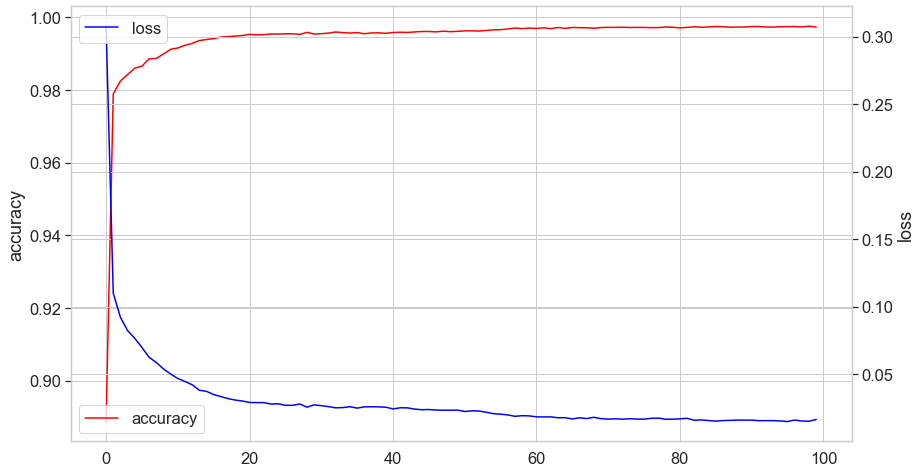

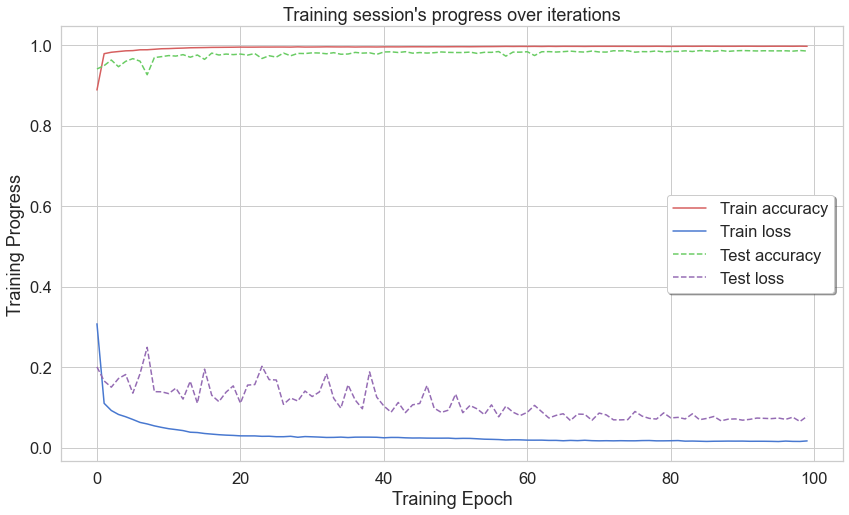

In [25]:
print(history.history.keys())
plot_train(history)
plot_train_session(history)
# plot_train_metric(history, "accuracy")
# plot_train_metric(history, "loss")

3633/3633 [==============================] - 5s 1ms/step - loss: 0.0281 - acc: 0.9953
Model evaluation:
Accuracy 0.99525	Loss 0.02806
Accuracy 0.99525


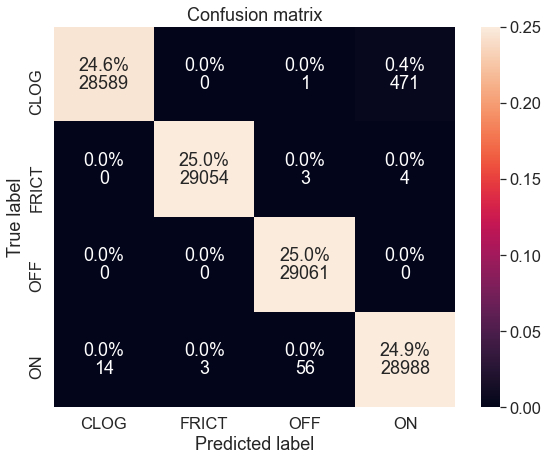

In [26]:
# Import and evaluate a model from File System (Keras)
# fs_model_keras = evaluate_fs_model_keras("model_fan_clsf.h5", X_full, y_full, 32)

Accuracy 0.99525


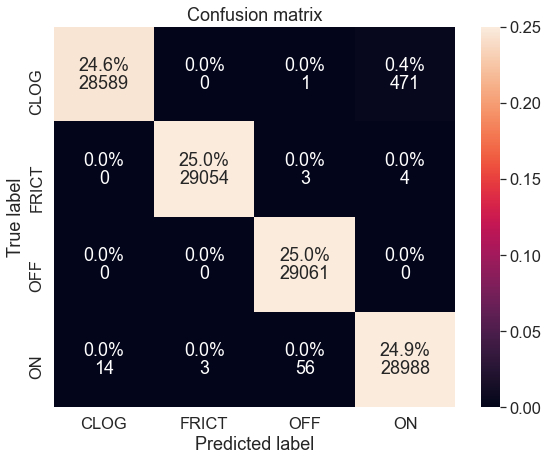

In [27]:
# Import and evaluate a model from File System (TF Lite)
# evaluate_fs_model_tflite("model_fan_clsf.tflite", X_full, y_full)

In [28]:
# Generate predictions for the fist 25 samples in the validation dataset
spl_st = DATA_SPLIT_TRAIN_SIZE
spl_sp = DATA_SPLIT_TRAIN_SIZE + 25
for i in range(N_CLASSES):
    print("\nClass: ", classes_name[i])
    predictions = model.predict(X_cls[i][spl_st:spl_sp])
    print("True labels: ", np.argmax(y_cls[i][spl_st:spl_sp], axis=1))
    print("Predictions: ", np.argmax(predictions, axis=1))



Class:  FAN-CLOG
True labels:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Predictions:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Class:  FAN-FRICTION
True labels:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Predictions:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]

Class:  FAN-OFF
True labels:  [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
Predictions:  [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]

Class:  FAN-ON
True labels:  [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
Predictions:  [3 3 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


### Export the model to filesystem in different formats (full, lite, quantized)

In [29]:
import tensorflow.lite as tflite
from tensorflow.lite.python.util import convert_bytes_to_c_source

def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(X_full).batch(1).take(100):
        # Model has only one input so each data point has one element.
        yield [input_value]
    
def convert_to_c(tflite_model, file_name):
    source_text, header_text = convert_bytes_to_c_source(tflite_model,  file_name)

    with  open("models/tensorflow/" + file_name + '.h',  'w')  as  file:
        file.write(header_text)

    with  open("models/tensorflow/" + file_name + '.cpp',  'w')  as  file:
        file.write("\n#include \"" + file_name + ".h\"\n")
        file.write(source_text)

def save_model(model, name):
    model_name_keras = name + ".h5"
    model_name_tflite = name + ".tflite"
    model_name_tflite_quant = name + "_quant.tflite"
    model_name_c = name + ".h"
    
    # store the keras model
    print("Save keras model")
    model.save("models/" + model_name_keras)
    
    # convert keras model into tf lite model
    print("Convert and save tf lite model")
    converter = tflite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()

    # convert keras model into quantized tf lite model
    print("Convert and save tf lite model - quantized")    
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.representative_dataset = representative_data_gen
#     converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
#     converter.inference_input_type = tf.int8  # or tf.uint8
#     converter.inference_output_type = tf.int8  # or tf.uint8
    tflite_model_quant = converter.convert()
    
    # store the tf lite models
    open("models/" + model_name_tflite, "wb").write(tflite_model)
    open("models/" + model_name_tflite_quant, "wb").write(tflite_model_quant)
    open("models/glow_" + model_name_tflite, "wb").write(tflite_model)
    open("models/glow_" + model_name_tflite_quant, "wb").write(tflite_model_quant)
    
    # convert to C source code and store it
    convert_to_c(tflite_model, name)
    convert_to_c(tflite_model_quant, name + "_quant")

    if GENERATE_GLOW_BUNDLE_EN:
        # generate the Glow bundles
        print("Generate the Glow bundles")
        !C:\nxp\Glow\bin\model-compiler.exe -model=models/glow_model_fan_clsf.tflite -emit-bundle=models/glow/ -backend=CPU -target=arm -mcpu=cortex-m7 -float-abi=hard -use-cmsis
        !C:\nxp\Glow\bin\model-compiler.exe -model=models/glow_model_fan_clsf_quant.tflite -emit-bundle=models/glow/ -backend=CPU -target=arm -mcpu=cortex-m7 -float-abi=hard -use-cmsis
        
    print("Done!")
    
save_model(model, "model_fan_clsf")

Save keras model
Convert and save tf lite model
INFO:tensorflow:Assets written to: C:\Users\nxf31578\AppData\Local\Temp\tmpd2xyepml\assets


INFO:tensorflow:Assets written to: C:\Users\nxf31578\AppData\Local\Temp\tmpd2xyepml\assets


Convert and save tf lite model - quantized
INFO:tensorflow:Assets written to: C:\Users\nxf31578\AppData\Local\Temp\tmpz7sswftz\assets


INFO:tensorflow:Assets written to: C:\Users\nxf31578\AppData\Local\Temp\tmpz7sswftz\assets


Generate the Glow bundles


I0204 09:47:57.879232 33104 HostManager.cpp:239] Destroying host manager...


Done!


I0204 09:47:58.287108 43872 HostManager.cpp:239] Destroying host manager...


In [ ]:
#xxd -c 13 -i model_fan_clsf.tflite > model_fan_clsf.h
#model-compiler.exe -model=models/model_fan_clsf -emit-bundle=models/model_fan_clsf/bundle -backend=CPU -target=arm -mcpu=cortex-m7 -float-abi=hard

### Real time data plot and model validation
This section will be used to plot real time data read from the board and also to validate the model and run predictions in real time. 
The board must be connected to the host machine and configured to log externally the sensor data.

In [30]:
import serial
import re

def ser_line_extract_data(raw_line):
    raw_str = raw_line.strip().decode('utf-8')
    # ['class','time[ms]','Ax', 'Ay', 'Az', 'Bx', 'By', 'Bz', 'T']
    raw_bytes = re.split(',', raw_str)
    if np.shape(raw_bytes)[0] != 9:
        return 0
    item = [raw_bytes[2], raw_bytes[3], raw_bytes[4]]
    # item = [raw_bytes[2], raw_bytes[3], raw_bytes[4], raw_bytes[8]]
    return item

def real_time_plot(serial_port):
    from jupyterplot import ProgressPlot
    sns.reset_orig()
    
    plot_names = []
    for i in range(N_CHANNELS): plot_names.append(str(i))
    pp = ProgressPlot(plot_names=plot_names)
    
    ser = serial.Serial(serial_port, 115200)
    ser.flushInput()

    item_0 = None
    while True:
        try:

            item = ser_line_extract_data(ser.readline())
            if item == 0: continue
            item = np.asarray(item, dtype= np.float64)  
            plot_items_list = []
            for i in range(N_CHANNELS): plot_items_list.append([item[i]])
            pp.update(plot_items_list)   
                
        except Exception as e:
            print(str(e))
            break
        except KeyboardInterrupt:
            print("KeyboardInterrupt")
            break

    ser.close()
    pp.finalize()
    
def real_time_validation(model, serial_port):
    ser = serial.Serial(serial_port, 115200)
    ser.flushInput()

    batch = []
    batch_idx = 0

    classTarget = 0
    predCount = 1
    predCountOk = 0
    predSize = 0
    predTarget = []
    predRes = []

    while True:
        try:
            if predCount >= predSize:
                classTarget = int(input("Model Evaluation: insert target class: "))
                predSize = int(input("Model Evaluation: insert pool size: "))

                predCountOk = 0
                predCount = 0
                predTarget = []
                predRes = []
                ser.flushInput()

            item = ser_line_extract_data(ser.readline())
            if item == 0: continue
                
            item = np.asarray(item, dtype= np.float32)
                
            batch.append(item)
            batch_idx += 1
            if batch_idx == FEED_WINDOW:
                batch = np.asarray(batch, dtype= np.float32).reshape(1, FEED_WINDOW, 1, N_CHANNELS)
                batch /= SENSOR_ACC_RESOLUTION
                classPred = np.argmax(model.predict(batch), axis=1)[0]
                predCount += 1
                batch_idx = 0
                batch = []

                predTarget.append(classTarget)
                predRes.append(classPred)

                # print(classes_name[classPred])
                if classTarget == classPred: predCountOk += 1
                print("Inference {:s}?{:s} | count: {:d}/{:d}/{:d}\t\r".format(
                    classes_name[classTarget], classes_name[classPred], predCountOk, predCount, predSize), end="")

            if predCount >= predSize:
                print("\r\nPrediction Accuracy for class {:s} {:.2f}%".format(classes_name[classTarget], (predCountOk * 100)/predCount))
                if np.shape(predTarget)[0] > 0:
                    confusion_matrix_plot(predTarget, predRes)
                    
        except Exception as e:
            print(str(e))
            ser.close()
            break
        except KeyboardInterrupt:
            print("KeyboardInterrupt")
            ser.close()
            break

    ser.close()

Model Evaluation: insert target class: 2
Model Evaluation: insert pool size: 50
Inference FAN-OFF?FAN-OFF | count: 50/50/50	
Prediction Accuracy for class FAN-OFF 100.00%
Accuracy 1.00000


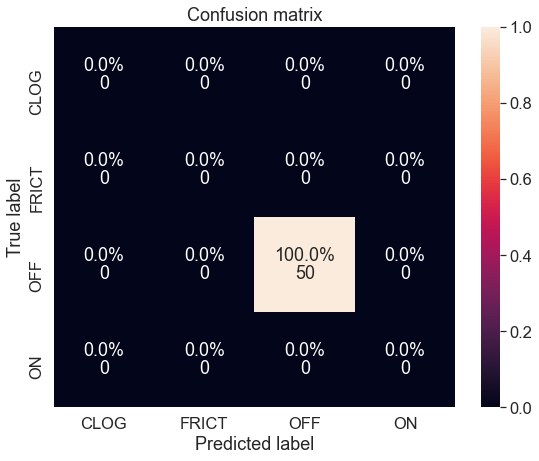

KeyboardInterrupt


In [31]:
real_time_validation(model, 'COM11')

In [36]:
real_time_plot('COM11')

KeyboardInterrupt
